In [4]:
!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
from datasets import load_dataset
import numpy as np
from transformers import CLIPProcessor, CLIPModel
from sklearn.cluster import KMeans
import cv2
import os
from pathlib import Path
import torch
import clip
from PIL import Image
from tqdm import tqdm #to view the progress bar
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import ast



In [4]:

dataset = load_dataset("datasetImg")

Using the latest cached version of the dataset since datasetImg couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\thayalan\.cache\huggingface\datasets\dataset_img\default\0.0.0\2c0e2d4d5df9bf2d (last modified on Fri Feb  6 17:43:50 2026).


In [5]:
dataset.column_names

{'train': ['image', 'label']}

In [6]:
len(dataset['train'])

10364

In [7]:
# Define your base directory (current folder)
base_path = Path.cwd()
dataset_dir = base_path / "furniture_dataset_folder"

data_list = []

# Iterate through folders
for img_path in dataset_dir.rglob("*.*"):
    if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
        
        # Get the path relative to the project root
        relative_path = img_path.relative_to(base_path)
        
        category = img_path.parent.name
        
        data_list.append({
            "image_id": img_path.stem,
            "relative_path": str(relative_path),
            "category": category,
            "furniture_colors": "" 
        })

# Create and Save CSV
df = pd.DataFrame(data_list)
df.to_csv("furniture_metadata.csv", index=False)

print(f"Done! Created manifest with {len(df)} entries.")

Done! Created manifest with 10364 entries.


In [8]:
df.head()

,image_id,relative_path,category,furniture_colors
0,00c5a9ad-579c-4260-8373-e9f6fe8e6399,furniture_dataset_folder\Bar Stool Dataset\202...,2025-07-08T22-31-54.094Z,
1,01017b39-5559-44a5-8e79-9dbb631b3821,furniture_dataset_folder\Bar Stool Dataset\202...,2025-07-08T22-31-54.094Z,
2,071de74b-00b8-41b1-8ebd-0e05144fdcaf,furniture_dataset_folder\Bar Stool Dataset\202...,2025-07-08T22-31-54.094Z,
3,07f02f08-7bc1-4ca1-aeaf-525d037f0f3e,furniture_dataset_folder\Bar Stool Dataset\202...,2025-07-08T22-31-54.094Z,
4,08aebfd6-4bca-45e4-9c03-beeeec61cc92,furniture_dataset_folder\Bar Stool Dataset\202...,2025-07-08T22-31-54.094Z,


Detecting the room type

In [9]:
# Load CLIP model (load only once)
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
print(f"CLIP loaded on {device}")


CLIP loaded on cpu


In [10]:

# Room label
room_labels = [
    "living room",
    "bedroom",
    "kitchen",
    "bathroom",
    "dining room",
    "home office",
    "hallway",
    "study room",
    "balcony",
    "garage",
    "gaming room"
]

# Precompute text features (embeddings don't change. Run only once)
text_tokens = clip.tokenize(room_labels).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)


In [ ]:
# def infer_room_type(image_path, top_k=1):
#     try:
#         img = Image.open(image_path).convert("RGB") #opens the image using Pillow
#     except Exception as e:
#         return f"Error: {e}"

#     img_input = preprocess(img).unsqueeze(0).to(device)

#     with torch.no_grad():
#         img_features = model.encode_image(img_input) #encodes the images
#         img_features /= img_features.norm(dim=-1, keepdim=True) #normalize

#         # Cosine similarity → softmax for probs
#         logits = (100.0 * img_features @ text_features.T).softmax(dim=-1)
#         probs = logits.cpu().numpy()[0]

#     # Top results
#     top_idx = np.argsort(probs)[::-1][:top_k]
    
#     print("Top match:")
#     results = []
#     for i, idx in enumerate(top_idx):
#         score = probs[idx] * 100
#         label = room_labels[idx]
#         print(f"{label}")
#         results.append((score, label))

    
#     return results



Extracting the colours of the img in the csv

In [13]:
from rembg import remove
import io

def extract_furniture_color_only(image_path, n_colors=3):
    
    if not os.path.exists(image_path):
        return "File Not Found"

    #Load and Remove Background
    with open(image_path, 'rb') as i:
        input_image = i.read()
    
    # This returns an RGBA image (Alpha channel is 0 for background)
    output_rgba = remove(input_image)
    img = Image.open(io.BytesIO(output_rgba)).convert("RGBA")
    
    # Prepare pixels for K-Means
    # Using pixels where the Alpha channel (mask) is not 0
    np_img = np.array(img)
    rgb_pixels = np_img[:, :, :3]
    alpha_mask = np_img[:, :, 3]
    
    # Filter out background pixels
    furniture_pixels = rgb_pixels[alpha_mask > 0]
    
    if len(furniture_pixels) == 0:
        return "No object detected"

    # K-Means on isolated pixels
    # Use a smaller sample if the image is huge to maintain speed
    if len(furniture_pixels) > 10000:
        idx = np.random.choice(len(furniture_pixels), 10000, replace=False)
        furniture_pixels = furniture_pixels[idx]

    kmeans = KMeans(n_clusters=n_colors, n_init=10, random_state=42)
    kmeans.fit(furniture_pixels)
    
    # Get dominant colors (RGB)
    colors = kmeans.cluster_centers_.astype(int)
    
    # Sort by frequency
    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    sorted_colors = colors[np.argsort(-counts)]
    
    return [tuple(c) for c in sorted_colors]

In [14]:
def img_colour_extraction(csv_path):
    df = pd.read_csv(csv_path)
    
    # Storage for the new data
    furniture_palettes = []
    
    print("Starting background-aware color extraction...")
    for _, row in tqdm(df.iterrows(), total=len(df)):
        path = row['relative_path']
        try:
            colors = extract_furniture_color_only(path, n_colors=3)
            furniture_palettes.append(str(colors))
        except Exception as e:
            furniture_palettes.append(f"Error: {str(e)}")
            
    df['furniture_colors'] = furniture_palettes
    df.to_csv("furniture_metadata_final.csv", index=False)
    print("Done! Metadata updated with isolated furniture colors.")



In [15]:
# img_colour_extraction("furniture_metadata.csv")

# new_df = pd.read_csv("furniture_metadata_final.csv")
# print(new_df.head())

Colour platte extraction of the user image

In [16]:

def extract_color_palette(image_path, n_colors=3, resize_to=(400, 400)):
    if not os.path.exists(image_path):
        return None
    img = cv2.imread(image_path)
    img = cv2.resize(img, resize_to)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pixels = img_rgb.reshape(-1, 3).astype(np.float32)
    kmeans = KMeans(n_clusters=n_colors, n_init=10, random_state=42)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_.astype(int)
    return [tuple(c) for c in colors]



In [17]:
#Calculating the distance of the colour palette
def calculate_color_distance(palette1, palette2):
   
    p1 = np.array(palette1)
    p2 = np.array(palette2)
    
    # Calculate Euclidean distance between colors
    distances = np.linalg.norm(p1 - p2, axis=1)
    
    return np.mean(distances)


In [18]:
def safe_parse_list(x):
    if pd.isna(x) or not isinstance(x, str):
        return []
    # If the string starts with 'Error' or 'No object', return empty list
    if x.startswith("Error") or x.startswith("No"):
        return []
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

Recommendations

In [19]:
#Filtering the data
def get_recommendations(user_img_path, vector_csv_path, top_k=5):
    # Load the database
    df = pd.read_csv(vector_csv_path)
    
    # Handle vectors
    df['feature_vector'] = df['feature_vector'].apply(safe_parse_list)
    # Filter out any rows that failed to parse into a valid vector
    df = df[df['feature_vector'].map(len) > 0]
    df['feature_vector'] = df['feature_vector'].apply(np.array)
    
    # Handle colors
    df['furniture_colors'] = df['furniture_colors'].apply(safe_parse_list)

    if df.empty:
        print("Error: The database is empty after filtering invalid rows.")
        return None

    # Process User Image for CLIP Vector
    user_img = Image.open(user_img_path).convert("RGB")
    user_input = preprocess(user_img).unsqueeze(0).to(device)
    with torch.no_grad():
        user_vec = model.encode_image(user_input)
        user_vec /= user_vec.norm(dim=-1, keepdim=True)
        user_vec = user_vec.cpu().numpy()
    
    # Process User Image for Colors
    user_palette = extract_color_palette(user_img_path)

    #Calculate Visual Similarity (CLIP)
    dataset_vecs = np.stack(df['feature_vector'].values)
    visual_sims = cosine_similarity(user_vec, dataset_vecs).flatten()
    
    # Calculate Colour Similarity
    color_scores = []
    for _, row in df.iterrows():
        # Check if row has valid colors 
        if not row['furniture_colors'] or not isinstance(row['furniture_colors'], list) or len(row['furniture_colors']) == 0:
            color_scores.append(1000) 
        else:
            dist = calculate_color_distance(user_palette, row['furniture_colors'])
            color_scores.append(dist)
    
    # Normalize colour score 
    max_dist = max(color_scores) if max(color_scores) > 0 else 1
    norm_color_score = 1 - (np.array(color_scores) / max_dist)
    
    #Final Weighted Score
    df['final_score'] = (visual_sims * 0.7) + (norm_color_score * 0.3)
    
    return df.sort_values(by='final_score', ascending=False).head(top_k)

In [20]:
def display_results(user_image_path, recommended_df):
    n = len(recommended_df)
    fig, axes = plt.subplots(1, n + 1, figsize=(22, 5))
    
    # Display Input
    axes[0].imshow(Image.open(user_image_path))
    axes[0].set_title("INPUT ROOM", fontweight='bold')
    axes[0].axis('off')
    
    # Display Matches
    for i, (idx, row) in enumerate(recommended_df.iterrows()):
        img_path = row['relative_path']
        axes[i+1].imshow(Image.open(img_path))
        axes[i+1].set_title(f"{row['category']}\nScore: {row['final_score']:.2f}")
        axes[i+1].axis('off')
    plt.show()


Main method

Searching for matches...


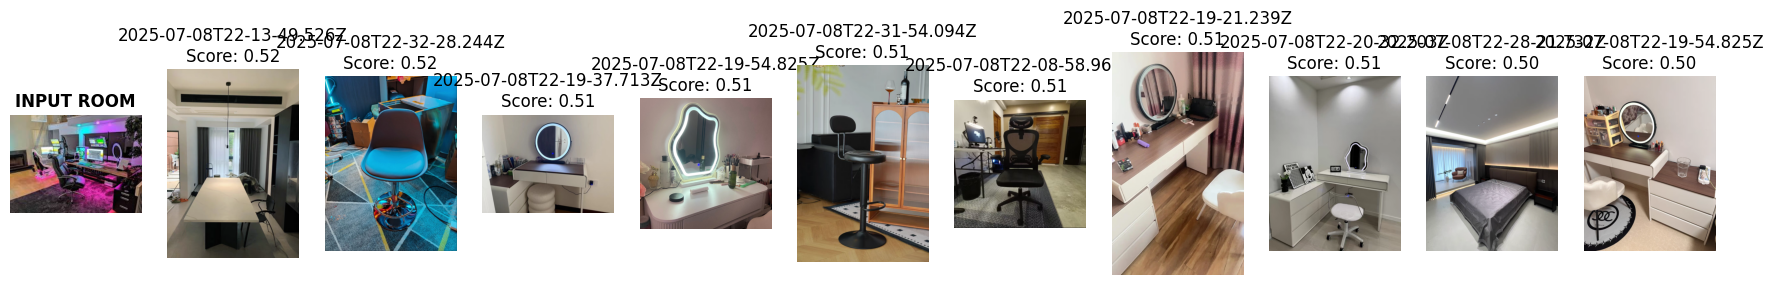

In [28]:
if __name__ == "__main__":
    user_image = os.path.join("images", "download (2).jpg")   
    vector_db = "furniture_metadata_vectors.csv"

    if not os.path.exists(user_image):
        print("Image not found!")
    else:
        try:
            # _room_type(user_image, top_k=1)
            extract_color_palette(user_image, n_colors=6)
            
            print("Searching for matches...")
            top_matches = get_recommendations(user_image, vector_db, top_k=10)
            display_results(user_image, top_matches)
            
        
        except Exception as e:
            print(f"Error: {e}")
